<a id="top"></a>
# Long Period TESS Targets with Kepler Counterparts
***


## Prerequisites
Before beginning this tutorial, you should be familiar with: 
- Python syntax, including [for loops](https://docs.python.org/3/reference/compound_stmts.html#for) and [try except](https://docs.python.org/3/reference/compound_stmts.html#try) blocks
- [astropy tables](https://docs.astropy.org/en/stable/table/index.html)
- [astropy Time objects](https://docs.astropy.org/en/stable/time/index.html)

## Learning Goals

By the end of this tutorial, you will:

- Load a .csv file as an astropy table and use criteria to filter the table into the rows and columns needed.
- Search the MAST archive by Kepler Input Catalog (KIC) number using astroquery.
- Load a catalog with Vizier to cross-match Kepler and TESS catalog identifiers.
- Search the MAST archive by criteria including TESS Input Catalog (TIC) number, type of observation, and dates of observation.
- Download and plot a lightcurve from the MAST archive.

## Introduction
The [Kepler initial and follow-on (K2) missions confirmed over 2,600 exoplanets](https://exoplanets.nasa.gov/keplerscience/) and contributed to an unprecedented exposion of knowledge about planetary systems in our galaxy. In addition to confirmed exoplanets, Kepler identified thousands more potential planetary candidates, referred to as Kepler Objects on Interest (KOI's). 

The Transiting Exoplanet Survey Satellite (TESS) began its observations just before the completion of the K2 mission; there may be long-period (greater than 6 months) exoplanets whose transits were observed by both missions. By combining observations from both missions, we could potentially view multiple transits and confirm the existence of new exoplanets. 

Possible transits observed by Kepler are called Threshold Crossing Events, or TCEs. More specifically, according to the [NASA Exoplanet Archive documentation](https://exoplanetarchive.ipac.caltech.edu/docs/Kepler_TCE_docs.html), 

>"A Threshold-Crossing Event (TCE) is a sequence of transit-like features in the flux time series of a given target that resembles the signature of a transiting planet to a sufficient degree that the target is passed on for further analysis."

The workflow for this notebook consists of:
* [Imports](#Imports)
* [Load full table of Kepler Threshold Crossing Events, or TCEs and filter by period](#Load-full-table-of-Kepler-Threshold-Crossing-Events,-or-TCEs-and-filter-by-period)
    * [Exercise 1](#Exercise-1)
* [Find all TESS 20 to 600-second targets for these Kepler TCEs](#Find-all-TESS-20-to-600-second-targets-for-these-Kepler-TCEs)
    * [Finding observations in the MAST archive by the Kepler ID number](#Finding-observations-in-the-MAST-archive-by-the-Kepler-ID-number)
    * [Exercise 2](#Exercise-2)
    * [Get coordinates and TESS Input Catalog (TIC) numbers from Vizier](#Get-coordinates-and-TESS-Input-Catalog-(TIC)-numbers-from-Vizier)
    * [Finding the number of TESS lightcurves by TIC](#Finding-the-number-of-TESS-lightcurves-by-TIC)
    * [Exercise 3](#Exercise-3)
* [Further limit the search for TESS lightcurves that were taken during predicted transit times](#Further-limit-the-search-for-TESS-lightcurves-that-were-taken-during-predicted-transit-times)
    * [Exercise 4](#Exercise-4)
* [Plot a TESS lightcurve that contains a predicted transit](#Plot-a-TESS-lightcurve-that-contains-a-predicted-transit)
    * [Exercise 5](#Exercise-5)
* [Additional Exercises](#Additional-Exercises)

## Imports
- *matplotlib.pyplot* for plotting data
- *numpy* to handle array functions
- *astropy.table Table* for creating tidy tables of the data
- *astroquery.mast Observations* for querying the MAST archive
- *lightkurve* for loading and plotting light curves
- *astropy.units* for keeping track of units
- *astroquery.vizier Vizier* for querying the VizieR Information System of astronomical catalogues
- *astropy.time Time* for handling dates and times of predicted transits

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Observations

import lightkurve as lk
import astropy.units as u # May not end up using?
from astroquery.vizier import Vizier
from astropy.time import Time

***

## Load full table of Kepler Threshold Crossing Events, or TCEs and filter by period

The NASA Exoplanet Archive hosts many useful data tables, including the list of [Threshold Crossing Events (TCEs)](https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html#tce). We'll use the Quarter 1 through Quarter 17 Data Release 24 (DR24) version. These TCEs were evaluated by an autovetter, a machine-learning program that classified TCEs into three categories: PC (Planet Candidate), AFP (Astrophysical False Positive), and NTP (Non-Transiting Phenomenon). More information about the autovetter can be found in [McCauliff et al. 2015 ApJ 806, 6](https://ui.adsabs.harvard.edu/abs/2015ApJ...806....6M/abstract).

The TCE website listed above provides URLs to the tables. It's possible to use astropy's Table function to read directly from a URL, however, those online versions do not contain all of the columns available in the TCE table. Instead, this tutorial includes a .csv file that was downloaded from the [TCE interactive table viewer](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=tce) with the options to "Download All Rows" and "Download All Columns" checked. Here we load the TCE DR24 table as an astropy table and view a preview with a "pretty-print" command.

In [2]:
tab=Table.read('./q1_q17_dr24_tce_2023.05.29_11.07.52.csv',format='ascii.csv',comment='#') 
tab.pprint()

rowid  kepid   tce_plnt_num ... tce_dikco_msky tce_dikco_msky_err
----- -------- ------------ ... -------------- ------------------
    1  1162345            2 ...        0.46282                1.1
    2  1292087            2 ...        0.22049               0.22
    3  1293031            2 ...        0.41872              0.207
    4  1162345            3 ...        0.13742              0.196
    5  1164109            1 ...         15.207             0.0893
    6   757450            1 ...        0.12498             0.0763
    7   892667            1 ...        0.18106              0.124
    8   892772            1 ...         5.2002              0.165
    9  1026032            1 ...       0.064587              0.077
   10  1026032            2 ...        0.13865              0.084
  ...      ...          ... ...            ...                ...
20357 11809346            1 ...       0.090355             0.0786
20358 11826440            2 ...        0.58446              0.755
20359 1185

As we can see, the table has over 20,000 rows, so we will want to narrow down by targets most of interest for us. However, the "pretty print" preview of the table does not show us all of the columns. Let's see the names of all of the columns, and only retain those we will need.

In [3]:
print(tab.columns)

<TableColumns names=('rowid','kepid','tce_plnt_num','tce_rogue_flag','tce_delivname','rowupdate','tce_datalink_dvs','tce_datalink_dvr','tce_period','tce_period_err','tce_time0bk','tce_time0bk_err','tce_time0','tce_time0_err','tce_ror','tce_ror_err','tce_dor','tce_dor_err','tce_incl','tce_incl_err','tce_impact','tce_impact_err','tce_duration','tce_duration_err','tce_ingress','tce_ingress_err','tce_depth','tce_depth_err','tce_eccen','tce_eccen_err','tce_longp','tce_longp_err','tce_limbdark_mod','tce_ldm_coeff1','tce_ldm_coeff2','tce_ldm_coeff3','tce_ldm_coeff4','tce_num_transits','tce_trans_mod','tce_full_conv','tce_model_snr','tce_model_chisq','tce_model_dof','tce_robstat','tce_dof1','tce_dof2','tce_chisq1','tce_chisq2','tce_chisqgofdof','tce_chisqgof','tce_prad','tce_prad_err','tce_sma','tce_sma_err','tce_eqt','tce_eqt_err','tce_insol','tce_insol_err','tce_nkoi','tce_ioflag','tce_quarters','tce_steff','tce_steff_err','tce_slogg','tce_slogg_err','tce_smet','tce_smet_err','tce_sradius','

The NASA Exoplanet Archive provides detailed information about the [Data Columns in the Kepler TCE Table](https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html). Some of the most important columns for us will be:
- kepid, Kepler identification number, which we can use when searching the MAST Archive.
- tce_period, the orbital period in days.
- tce_period_err, the error in the orbital period (also in days).
- tce_time0bk, the time of the center of the first detected transit in Barycentric Julian Day (BJD) minus a constant offset of 2,454,833.0 days. The offset corresponds to 12:00 on Jan 1, 2009 UTC.
- tce_time0bk_err, the error in the above (also in days)
- tce_depth, the fraction of stellar flux lost at the maximum of the transit, in ppm.
- tce_duration, the duration of the observed transit, in hours.
- av_pred_class, the autovetter predicted classification (PC, AFP, or NTP)

We will only use those columns for now, to reduce the size of the table we are dealing with.

In [4]:
tab=tab['kepid','tce_period','tce_period_err','tce_time0bk','tce_time0bk_err','tce_depth','tce_duration','av_pred_class']

Additionally, we'd like to filter our table to only include Planetary Candidates of with a TCE period of greater than 6 months, or 180 days. First, only include those that the autovetter indicated as "PC" for Planetary Candidate.

In [5]:
tab=tab[tab['av_pred_class']=='PC']
print('Number of Kepler TCEs marked as Planetary Candidates:',len(tab))

Number of Kepler TCEs marked as Planetary Candidates: 3900


We can see that of the over 20,000 TCEs, just under 20% were identified as likely planetary candidates (PCs). 
What is the distribution of the periods of those PCs? We can view a histogram of the 'tce_period' column.

Text(0, 0.5, 'Number of PCs')

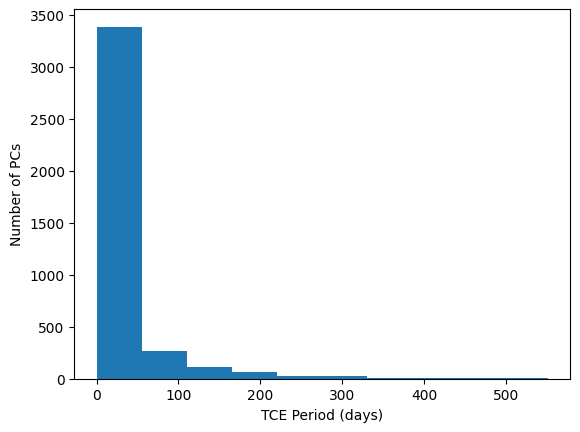

In [6]:
plt.hist(tab['tce_period'])
plt.xlabel('TCE Period (days)')
plt.ylabel('Number of PCs')

The vast majority of the TCE periods are fewer than 50 days. The planetary candidates that would most benefit from the long baseline afforded by combining the Kepler, K2, and TESS datasets are those with longer periods. Here, we'll again filter our table to just include those PCs with periods of greater than 6 months, or 180 days. 

In [7]:
tab=tab[tab['tce_period']>180]
n=len(tab)
print('Number of Kepler TCEs marked PC and period > 180 days:',n)

Number of Kepler TCEs marked PC and period > 180 days: 123


### Exercise 1
Go to the [Data page of the NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/docs/data.html) and download the TCE table with all columns and all rows. Load it here and confirm that it matches the .csv file included with the tutorial. Then, sort your new table to include only Non-Transiting Phenomena with periods of less than or equal to 180 days. 

In [8]:
### Write your code for Exercise 1 here. 

## Find all TESS 20 to 600-second targets for these Kepler TCEs
The Kepler and K2 missions studied a limited portion of the sky, but TESS has studied the full sky. This means that all Kepler and K2 identifications are likely to be included in the TESS Catalog. However, they may not all have photometry data collected at small enough intervals; some may be as high as 1800 seconds or 30 minutes between data points on the light curve. For transits that only last on the order of hours, this may not be frequent enough to confidently confirm the transit. We will search the archive for cadences of up to 10 minutes (or 600 seconds).

### Finding observations in the MAST archive by the Kepler ID number
When we use astroquery.mast's Observations.query_object or query_object_count functions, the object's name will be resolved into sky coordinates (RA and Dec), so that all observations of that coordinate will be returned. This allows us to search by the Kepler ID column, even though TESS will not have used the Kepler ID to refer to the name of the target. Likewise, other ways to search the MAST archive, such as query_criteria, will also resolve the coordinates of the name input to 'objectname'. See the [astroquery documentation about MAST Queries](https://astroquery.readthedocs.io/en/latest/mast/mast.html) for more information. 

Unfortunately, this method of searching is time-intensive, which makes it very inconvenient when cross-matching hundreds or more targets from different missions. Let's illustrate this point with the first row in our filtered table. We will query all observations in MAST that correspond to the coordinates of the first row's Kepler ID, within 1 arcsecond. Notice that this call to MAST will take at least a few seconds; we can use the "time" magic command to tell us how long it takes.

In [9]:
print('Kepler ID of first row: '+str(tab[0]['kepid']))
%time obs_table = Observations.query_object('KIC '+str(tab[0]['kepid']),radius=1*u.arcsec)

Kepler ID of first row: 2581316
CPU times: user 56.5 ms, sys: 15 ms, total: 71.5 ms
Wall time: 6.34 s


Let's view a preview of the resulting table.

In [10]:
# View the observation table
obs_table.pprint()

intentType obs_collection provenance_name ... srcDen   obsid   distance
---------- -------------- --------------- ... ------ --------- --------
   science           TESS            SPOC ...    nan  27463635      0.0
   science           TESS            SPOC ...    nan  62431369      0.0
   science           TESS            SPOC ...    nan  62870781      0.0
   science           TESS            SPOC ...    nan  92616912      0.0
   science           TESS            SPOC ...    nan  95133363      0.0
   science           TESS            SPOC ...    nan  62349937      0.0
   science           TESS            SPOC ...    nan  62793303      0.0
   science           TESS            SPOC ...    nan  91547081      0.0
   science           TESS            SPOC ...    nan  93772051      0.0
   science    SPITZER_SHA    SSC Pipeline ...    nan   1730213      0.0
       ...            ...             ... ...    ...       ...      ...
   science           HLSP             QLP ...    nan 129964724  

The 89 rows of the table include observations from mulitple missions. The 'target_name' column (not shown in the preview) contains a number of different entries. Let's view the list of unique entries in that column.

In [11]:
np.unique(obs_table['target_name'])

137685450
2144.049
Kepler10-1-2-1-1-1-1-1
--
TESS FFI
TICA FFI
kplr002581316


From the above, we can see that inputting an 'objectname' of 'KIC 2581316' from the Kepler Input Catalog (KIC) identification number, we find all the observations of that target from all different missions - even if they did not specifically refer to the name of the target by the same name. While this is very helpful for cross-matching targets from different catalogs, the amount of time it takes to do so is prohibitive if we want to examine hundreds or thousands of targets.

Moreover, if we're interested in *only* TESS observations light curves, then we will only need to return observations whose target name matches the TESS ID number. The table above includes observations from other missions (e.g. Kepler) or other types of data products from TESS (e.g. full-frame-images, from which lightcurves have already been extracted).

### Exercise 2
One of the target names listed above, '137685450', turns out to be the TESS Input Catalog (TIC) identifier for this target. Search the MAST archive by this object name, with the same search radius of 1 arcsecond, and confirm that the two result tables are identical. Do you need to add 'TIC' and input the number as string like we did above, or can you just use the number alone?

In [12]:
### Write your code for Exercise 2 here. 
### JRK Solution here for now, put in other notebook later.
# You DO need to tell the query_object routine that you are inputting a TIC number. 
# Inputting the number alone (as a string or an integer) will result in an error.
obs_table2 = Observations.query_object('TIC '+str(137685450),radius=1*u.arcsec)
# We can check that the two tables have the same length and contain the same unique list of target names. 
print(len(obs_table2))
print(np.unique(obs_table2['target_name']))

89
     target_name      
----------------------
             137685450
              2144.049
Kepler10-1-2-1-1-1-1-1
                    --
              TESS FFI
              TICA FFI
         kplr002581316


### Get coordinates and TESS Input Catalog (TIC) numbers from Vizier
We will find that it is far faster to search MAST for TESS observations  by TESS Input Catalog (TIC) number. To do that, we need to figure out the TICs that correspond to the KICs. To do this, we'll search the Tess Input Catalog, which is hosted in Vizier: [TESS Input Catalog version 8.2 (TIC v.8.2)(Paegert+,2021)](http://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=IV/39/tic82&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa)

First, we'll setup astroquery to search Vizier in such a way that we do not limit the number of rows returned, and we specifically want to return the columns corresponding to coordinates (RA and Dec), TIC, and KIC. Next, we'll create new columns in our table (tab) that match the data types we will find in Vizier.

In [13]:
Vizier.ROW_LIMIT = -1
v=Vizier(columns=['_RAJ2000','_DEJ2000','TIC','KIC'])

In [14]:
tab.add_columns([np.zeros(n),np.zeros(n),np.zeros(n,dtype=np.int32),np.zeros(n,dtype=np.int64)],
                names=['_RAJ2000','_DEJ2000','KIC','TIC'])

We will query Vizier for each row in our table of TCEs, and then save the resulting RA, Dec, KIC (just to confirm!) and TIC in our new columns. To guard against connectivity errors interrupting the workflow, we will put the Vizier query in a [try statement](https://docs.python.org/3/tutorial/errors.html#handling-exceptions).

In [15]:
# Query a subset of the TESS Input Catalog 
#result=Vizier.query_object('KIC 2581316',catalog=['IV/39/tic82']) # Length: 282
#for i,row in enumerate(tab):
for i,row in enumerate(tab):
    # Use a "try/except" because sometimes there is no response
    try:
        result=v.query_object('KIC '+str(row['kepid']),radius=1*u.arcsec,catalog=['IV/39/tic82'])
        # If there is more than one result, choose the one with matching KIC.
        if len(result[0])>1: result=result[0][result[0]['KIC']==row['kepid']]
        tab[i]['_RAJ2000','_DEJ2000','KIC','TIC']=result[0][0]['_RAJ2000','_DEJ2000','KIC','TIC']
    except:
        print('Error in',i)
        continue

Error in 58
Error in 75


We can now view the updated table and confirm that the KIC values from Vizier match the 'kepid' values from our original table, except in any rows where an error was found.

In [16]:
tab.pprint()
print(np.where(tab['kepid']!=tab['KIC']))
print(tab[[58,75]])

 kepid   tce_period tce_period_err ...    _DEJ2000      KIC       TIC   
-------- ---------- -------------- ... -------------- -------- ---------
 2581316    217.832    7.71254e-05 ... 37.86013507452  2581316 137685450
 2975770    369.079     0.00262336 ... 38.11458125146  2975770 121395761
 2576107    205.583    0.000156979 ... 37.88763673242  2576107 137220754
 3103227    225.583     0.00304541 ... 38.29470683575  3103227 121395435
 3326377     198.71    0.000624291 ... 38.40533619115  3326377 120962548
 3645438    386.372      0.0107079 ... 38.78773924713  3645438 137151626
 3634051    453.544     0.00352963 ... 38.74028625567  3634051 121457557
 3747817    184.772     0.00139617 ... 38.87490712824  3747817 137319097
 4918309    186.436     0.00047676 ... 40.02181730105  4918309 122301308
 4760478    287.378      0.0024477 ... 39.88652749598  4760478 184011870
     ...        ...            ... ...            ...      ...       ...
11026582    240.572     0.00146005 ... 48.558688961

Comparing the 'kepid' and 'KIC' columns in the above table, we can see that they match, except in rows 58 and 75, where an error resulted in no result. 

### Finding the number of TESS lightcurves by TIC
To examine each of the 123 long-period planetary candidates that also have TESS lightcurves, it is more efficient to just query MAST for the counts (total numbers) of observations that match our criteria; we can do this with query_criteria_count. Here are the criteria we will include:
- target_name, the TIC number as an integer.
- project = TESS
- obs_collection = HLSP for "High Level Science Product"
- dataproduct_type = 'timeseries' because we are interested in light curves, not images
- t_exptime = [20.0,600.0], this limits ourselves to lightcurves with observing cadences (time between images) of 20 to 600 seconds. Some TESS light curves in the MAST archive are 1800.0 s or 30 minutes; because exoplanet transits last on the order of hours, we'll be better able to model the transit with higher frequency images.
First, we'll add a column of integers to our table to indicate the number of TESS observations matching our criteria.

In [17]:
tab.add_column(np.zeros(n,dtype=int),name='nTESS')

Now, with a for loop, we will use query_criteria_count on each row, one at a time, and record the number of matching observations.

In [18]:
# For each row in the table, record the total number of observations that meet the criteria listed above.
for i,row in enumerate(tab):
    obs_count = Observations.query_criteria_count(target_name=row['TIC'],
                                        project='TESS',obs_collection='HLSP',
                                        dataproduct_type='timeseries',
                                       t_exptime=[20.0,600.0])
    tab['nTESS'][i]=obs_count

Finally, we'll only keep the rows of our table where at least 1 TESS light curve matching our criteria was found, and view a preview of the resulting table.

In [19]:
tab=tab[tab['nTESS']>0]
tab.pprint()

 kepid   tce_period tce_period_err tce_time0bk ...   KIC       TIC    nTESS
-------- ---------- -------------- ----------- ... -------- --------- -----
 2581316    217.832    7.71254e-05      238.82 ...  2581316 137685450     8
 2975770    369.079     0.00262336      298.39 ...  2975770 121395761     3
 3634051    453.544     0.00352963      360.06 ...  3634051 121457557     2
 4862625    541.739     0.00356943      374.46 ...  4862625 170348142     3
 4820550    202.118    0.000378617     292.048 ...  4820550 121013026     4
 4638237     290.14    0.000270323     307.251 ...  4638237 120765843     4
 5437945    440.784    0.000998579     139.352 ...  5437945 121603086     4
 5437945    220.129    0.000705592     245.991 ...  5437945 121603086     4
 5652983    498.393     0.00211404     244.081 ...  5652983 172422658     3
 6368905    220.718     0.00447089     303.846 ...  6368905 138098637     2
     ...        ...            ...         ... ...      ...       ...   ...
11152511    

It appears that 55 of our 123 candidates have TESS lightcurves that meet our criteria. From what we can see of the last column, many of them have multiple light curves available in the MAST database!

### Exercise 3
For each of the remaining 55 candidates, determine how many Kepler lightcurves (of any cadence) are available in the MAST archive. Save this information as another column in the 'tab' table. 

In [20]:
### Write your code for Exercise 3 here. 

## Further limit the search for TESS lightcurves that were taken during predicted transit times
Recall that our TCE table included fit information about the time of first detected transit and the period of the transit. We can use that information to estimate when predicted transits may happen, and limit our search criteria to include only those time periods.

If the first transit happens on (offset) date/time $t_0 =$ 'tce_time0bk', and the period is $p =$ 'tce_period', then the $n$'th transit thereafter happens at $t_n = t_0 + n*p$. The error in that final timing will be $\sqrt{\sigma_{t_0}^2+(n \sigma_p)^2}$; consider the sizes of the uncertainties reported in 'tce_time0bk_err' and 'tce_period_err', you can show (as an Exercise, below) that these errors will be very small and we will not need to consider them in our search queries. 

TESS observed the sky in sectors for 27.4 days at a time. For predicted transit times $t_n$, we are interested in finding light curves that start between 1 and 27 days before $t_n$, and end between 1 and 27 days after $t_n$, to assure that the predicted transit time falls somewhere in the sector's timeframe. 

For this portion of the tutorial, the astropy.time package will be particularly important; you can review the astropy documentation about [Dates and Times](https://docs.astropy.org/en/stable/time/index.html). Additionally, it's important to note that the start and end times in MAST (t_min and t_max) should be searched by MJD or "Modified Julian Date" which is the Julian Date minus 2400000.5, a number we'll assign to the variable to_mjd.

In [21]:
to_mjd=2400000.5

First, we'll add three columns to our table. 'nTESStimed' will be a place to record the total number of TESS observations that are timed correctly to include a predicted transit. If we find one, we'll want to record the MJD that corresponds to that predicted transit in column 't_n MJD 1'. Finally, I've added another column ('t_n MJD 2') in case this target has another predicted transit in the TESS archive.

In [22]:
tab.add_column(0,name='nTESStimed')
tab.add_column(0.0,name='t_n MJD 1')
tab.add_column(0.0,name='t_n MJD 2')

Now we will calculate the predicted times ($t_n$) of the next 30 transits, starting from the first transit measured by Kepler. Remember that the Kepler TCE table gave those times as dates offset by 2454833.0. Of those 30 transits, we will only keep those from 2018 to today's date. For each of the remaining $t_n$ values, we'll do a query_criteria_count call for observations that met the criteria we've already searched once, plus the extra criteria that they begin 27 to 1 day before $t_n$ and end 1 to 27 days after $t_n$. Finally, we'll add the count of observations found to the appropriate row of the 'nTESStimed' column.

JRK note, not sure what causes the "ERFA function "d2dtf" yielded 13 of "dubious year (Note 5)" and so on errors. IT appears to be related to "5) The warning status "dubious year" flags UTCs that predate the
           introduction of the time scale or that are too far in the future
           to be trusted.  See eraDat for further details."
https://pyerfa.readthedocs.io/en/latest/_modules/erfa/core.html
But if I'm not using dates in the future, why....?

In [23]:
for i,row in enumerate(tab):
    # Possible date/times of central transits, offset.
    t_n=row['tce_time0bk']+row['tce_period']*np.arange(30)
    # Convert this array of floats to one of DateTime objects, in Barycentric Julian Days
    t_n=Time(t_n+2454833.0,format='jd')
    # Only test those from 2018-today's date
    t_n=t_n[t_n.ymdhms.year>=2018]
    t_n=t_n[t_n<=Time.now()]
    for j,time in enumerate(t_n):
        # Look for TESS observations that start 27 to 1 day before predicted central transit,
        # and end 1 day to 27 days after predicted central transit
        obs_count = Observations.query_criteria_count(target_name=row['TIC'],
                                              project='TESS',obs_collection='HLSP',
                                              dataproduct_type='timeseries',
                                              t_exptime=[20.0,600.0],
                                              t_min=[time.value-to_mjd-27,time.value-to_mjd-1],
                                              t_max=[time.value-to_mjd+1,time.value-to_mjd+27])
        # Add the number of observations found to the count.
        tab['nTESStimed'][i]+=obs_count
        # If observations were found, record the date (MJD) of predicted transit
        if obs_count>0 and tab['t_n MJD 1'][i]==0:
            tab['t_n MJD 1'][i]=time.value-to_mjd
        # If observations were found, but we already recorded a date, record this new date in the 2nd column.
        elif obs_count>0 and tab['t_n MJD 1'][i]!=0:
            tab['t_n MJD 2'][i]=time.value-to_mjd
        # If observations were found, but we already recorded two dates, print an error.
        elif obs_count>0 and tab['t_n MJD 2'][i]!=0:
            print('ERROR! Missing a predicted time MJD for KIC ',row['KIC'])
    # Print brief update every 10 targets as the loop continues
    if np.mod(i,10)==0: print('Finished row ',i)

Finished row  0


/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 13 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 16 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 18 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 8 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 15 of "dubious year (Note 5)"
  warning

Finished row  10


/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 3 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 10 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 5 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 12 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 2 of "dubious year (Note 5)"
  warnings.

Finished row  20


/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 7 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 9 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 4 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Finished row  30


/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 14 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 6 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Finished row  40


/opt/conda/envs/tess/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 11 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Finished row  50


Now, we'll further limit our table to targets that have TESS observations with the right timing, and view some of the most relevant columns of the table.

In [24]:
tab=tab[tab['nTESStimed']>0]
tab['kepid','tce_depth','nTESS','nTESStimed','t_n MJD 1','t_n MJD 2']

kepid,tce_depth,nTESS,nTESStimed,t_n MJD 1,t_n MJD 2
int64,float64,int64,int64,float64,float64
2581316,9230.0,8,2,59427.95999999996,0.0
4820550,2742.0,4,1,59773.262000000104,0.0
4638237,4838.0,4,1,59781.99099999992,0.0
5437945,2915.0,4,1,59820.47599999979,0.0
6762829,441.4,8,4,59395.35900000017,59810.481000000145
8105398,389.9,4,1,59432.398000000045,0.0
8264402,379.4,5,2,59422.950000000186,0.0
9086154,415.5,4,1,59788.02499999991,0.0
9002278,468.4,10,2,59431.46299999999,0.0


The first row in the table, which corresponds to KIC 2581316, has 8 total TESS lightcurves from 20 to 600-second cadence, but only 2 of them are timed such that they might capture a predicted transit. More specifically, those two lightcurves likely capture the transit that is predicted to happen on Modified Julian Day 59427.96. According to the output of the cell below, this is in August 1st, 2021 at 23:02 UTC. Also, according to our table, this planet candidate has the largest predicted depth of all of our 14 remaining targets, so it will be a great target to investigate in more detail.

In [25]:
Time(59427.96,format='mjd').ymdhms

(2021, 8, 1, 23, 2, 23.99999993)

### Exercise 4
For the first target in the table (row 0), find the year, month, and day (in UTC) of all predicted transits from 2018 until today. Use propagation of error (and the formula presented to you above, $\sqrt{\sigma_{t_0}^2+(n \sigma_p)^2}$) to determine the error on the predicted transits. Is the error on the order of minutes, days, or weeks? 

In [26]:
# Write your code for Exercise 4 here.
# Solution here for now
row=tab[0]
# The first part can be accomplished using the same code as in the loop, and then printing the result with the formatting of "ymd" for year month day.
# Possible date/times of central transits, offset.
t_n=row['tce_time0bk']+row['tce_period']*np.arange(30)
# Convert this array of floats to one of DateTime objects, in Barycentric Julian Days
t_n=Time(t_n+2454833.0,format='jd')
# Only test those from 2018-today's date
t_n=t_n[t_n.ymdhms.year>=2018]
t_n=t_n[t_n<=Time.now()]
# Print the remaining t_n values in a format from which we can easily see year, month, day.
print([x.ymdhms for x in t_n])
# Propagate error.
t_n_err=np.sqrt(row['tce_time0bk_err']**2 + (np.arange(30)*row['tce_period_err'])**2)
# Print the errors. Note that the units of all the quantities above were in days, so is our final result.
print(t_n_err)
# The errors are small. Multiply by the number of minutes in a day, 24*60.
print(t_n_err*24.0*60.0)
# The errors are on the order of minutes.

[(2018, 1, 2, 23, 13, 55.19998938), (2018, 8, 8, 19, 11, 59.99998391), (2019, 3, 14, 15, 10, 4.80001867), (2019, 10, 18, 11, 8, 9.6000132), (2020, 5, 23, 7, 6, 14.40000773), (2020, 12, 27, 3, 4, 19.20000225), (2021, 8, 1, 23, 2, 23.99999678), (2022, 3, 7, 19, 0, 28.79999131), (2022, 10, 11, 14, 58, 33.59998584), (2023, 5, 17, 10, 56, 38.39998037)]
[0.00028531 0.00029555 0.00032434 0.00036734 0.00042021 0.0004797
 0.00054364 0.00061063 0.00067977 0.00075048 0.00082233 0.00089507
 0.00096848 0.00104243 0.00111681 0.00119154 0.00126656 0.00134181
 0.00141727 0.0014929  0.00156867 0.00164457 0.00172058 0.00179668
 0.00187287 0.00194913 0.00202546 0.00210184 0.00217828 0.00225476]
[0.41084352 0.42559    0.46704411 0.52896357 0.60509803 0.69076312
 0.78283629 0.87930684 0.97887553 1.08068634 1.18416112 1.28889916
 1.39461587 1.5011045  1.60821171 1.71582167 1.82384539 1.93221347
 2.04087106 2.14977427 2.25888756 2.3681819  2.47763334 2.58722192
 2.69693094 2.80674627 2.9166559  3.02664956 3.

# Plot a TESS lightcurve that contains a predicted transit

Let's examine the first row in the table.

In [27]:
i=0
row=tab[i]
print(row['kepid'])

2581316


Create a Time object of the time of the predicted transit.

In [28]:
time=Time(row['t_n MJD 1'],format='mjd')

Instead of just getting the total number of counts, we now want to query for the actual observations themselves. We'll use all the same criteria we've been using above. For the rest of the tutorial, you may with to review the astroquery.mast documentation on [Downloading Data](https://astroquery.readthedocs.io/en/latest/mast/mast.html#downloading-data).

In [29]:
# Now actually query the observation table
obs_table = Observations.query_criteria(target_name=row['TIC'],
                                              project='TESS',obs_collection='HLSP',
                                              dataproduct_type='timeseries',
                                              t_exptime=[20.0,600.0],
                                              t_min=[time.value-27,time.value-1],
                                              t_max=[time.value+1,time.value+27])
obs_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str9,str10,str4,str4,str7,str9,str1,str58,float64,float64,str10,str19,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str47,str1,str116,str6,bool,float64,str8,str9
science,HLSP,TESS-SPOC,Photometer,TESS,TESS,Optical,137685450,--,hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_tp,292.62745521591,37.8601350745185,timeseries,Douglas A. Caldwell,4,59419.495390972224,59446.07849778935,600.0,600.0,1000.0,--,59821.0,N/A,--,41,CIRCLE ICRS 292.62745522 37.86013507 0.00111111,--,mast:HLSP/tess-spoc/s0041/target/0000/0001/3768/5450/hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_lc.fits,PUBLIC,False,nan,90647225,174135111
science,HLSP,QLP,Photometer,TESS,TESS,Optical,137685450,--,hlsp_qlp_tess_ffi_s0041-0000000137685450_tess_v01_llc,292.627455216,37.8601350745,timeseries,Chelsea X. Huang,4,59419.49274204578,59446.07584918942,600.0,600.0,1000.0,--,59844.51684021,N/A,--,41,CIRCLE ICRS 292.62745522 37.86013507 0.00111111,--,mast:HLSP/qlp/s0041/0000/0001/3768/5450/hlsp_qlp_tess_ffi_s0041-0000000137685450_tess_v01_llc.fits,PUBLIC,False,nan,94090194,178725662


Based on the above table, the two light curves corresponds to the same sector (they have the same t_min and t_max, or start and end times), but one was created by the [TESS Science Processing Operations Center (SPOC) pipline](https://archive.stsci.edu/hlsp/tess-spoc) and one was created by the [MIT Quick-Look Pipeline "QLP" team](https://archive.stsci.edu/hlsp/qlp). For this tutorial, we'll look at the first one in the list from TESS-SPOC. We can use Observations.get_product_list to find the data products associated with this observation.

In [30]:
data_prod = Observations.get_product_list(obs_table[0])
data_prod

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str4,str10,str58,str4,str1,str116,str7,str28,str1,str1,str9,str2,str3,str63,int64,str8,str6,int64
90647225,HLSP,timeseries,hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_tp,FITS,C,mast:HLSP/tess-spoc/s0041/target/0000/0001/3768/5450/hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_lc.fits,SCIENCE,Minimum Recommended Products,--,--,TESS-SPOC,59,N/A,hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_lc.fits,411840,90647225,PUBLIC,4
90647225,HLSP,timeseries,hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_tp,FITS,C,mast:HLSP/tess-spoc/s0041/target/0000/0001/3768/5450/hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_tp.fits,SCIENCE,Minimum Recommended Products,--,--,TESS-SPOC,59,N/A,hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_tp.fits,9411840,90647225,PUBLIC,4


The two data products are the lightcurve itself (whose productFilename ends in _lc.fits) and the target pixel file from which the light curve was derived (whose productFilename ends in _tp.fits). We will choose the row that ends in _lc.fits and download it.

JRK the data-access.ipynb in TIKE has a more elegant way to do this, however I don't seem to find any other way to distinguish the two data products. They have the same dataproduct_type (timeseries) and same description (FITS). Also, I tried a different target, and its ended in _llc.fits not _lc.fits.

In [31]:
manifest=Observations.download_products(data_prod[[x.endswith('lc.fits') for x in data_prod['productFilename']]])

INFO: Found cached file ./mastDownload/HLSP/hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_tp/hlsp_tess-spoc_tess_phot_0000000137685450-s0041_tess_v1_lc.fits with expected size 411840. [astroquery.query]


The lightkurve package makes analyzing time series data very easy. Below, we'll read in the file that we just downloaded, plot the lightcurve, and mark a vertical line that corresponds to the time (Julian Day-2457000 days) of the predicted transit.

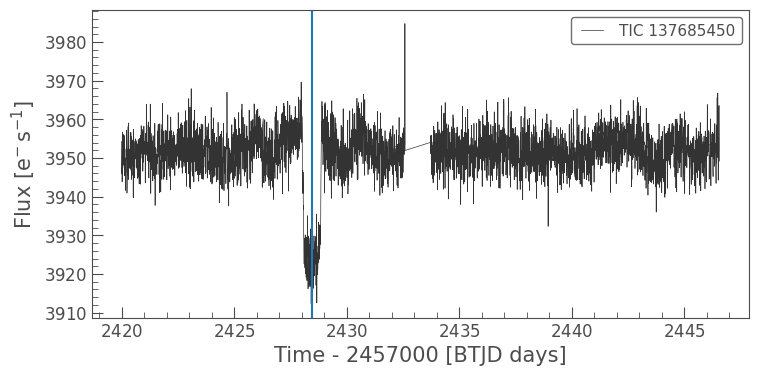

In [32]:
lc=lk.read(manifest['Local Path'][0])
lc.plot()
plt.axvline(time.jd-2457000)

Wow! The transit is clearly visible at the exact time that was predicted by the Kepler TCE model. In fact, according to the NASA Exoplanet Archive, this exoplanet was confirmed as [Kepler-1514 b](https://exoplanetarchive.ipac.caltech.edu/overview/TIC%20137685450) in 2016 by [Morton et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...822...86M/abstract). Additionally, another smaller planet, Kepler-1514 c, was discoverd in 2020 orbiting this star with a period of 10.5 days. 

### Exercise 5
Choose another target from our table (tab), and download and plot a TESS lightcurve that likely contains one of the predicted transits. Confirm that the lightcurve contains the predicted transit time.

JRK - maybe it's best I pick one for them so they can check solutions...

In [33]:
# Write your code for Exercise 5 here.

## Additional Exercises

6. Investigating Planetary Candidates:
* a. Use the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/) to examine the 14 Kepler TCE Planetary Candidates in our most refined table. Which ones have since been confirmed as exoplanets? Which ones remain Planetary Candidates?
* b. JRK something about doing the above procedure with one of the planetary candidates. 

7. Alternative search priorities: In the beginning of this tutorial, we focused on planetary candidates with long periods (> 6 months). Alternatively, you could choose to focus your search on planetary candidates with the largest transit depth, irrespective of period. You could also choose to investigate possible astrophysical false positives instead of planetary candidates. Design your own search procedure to use TESS spectra to learn more about Kepler TCE's. Justify the choices you are making; how are you narrowing down your target list, and why? What criteria will you use to determine which TESS spectra are applicable? Plot at least one spectrum that meets your criteria.

## Citations

If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* Citing `astroquery`
* Citing `VizieR`?
* Citing MAST?

## About this Notebook
Let the world know who the author of this great tutorial is! If possible and appropriate, include a contact email address for users who might need support (for example, `archive@stsci.edu`). You can also optionally include keywords, your funding source, or a last update date in this section.

**Author(s):** Julia Kamenetzky, ScienceBetter consultant <br>
**Keyword(s):** Tutorial, lightkurve, kepler, tess, cross-matching, query_criteria<br>
**Last Updated:** Jun 2023 <br>
**Next Review:** Dec 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 